# Dfs0

In [62]:
import numpy as np
import pandas as pd

## Reading data

In [63]:
from mikeio import Dfs0

dfs = Dfs0("data/TemporalEqTime.dfs0")
dfs

<mikeio.Dfs0>
Timeaxis: TimeAxisType.TimeEquidistant
Items:
  0:  WaterLevel item <Water Level> (meter)
  1:  WaterDepth item <Water Depth> (meter)

In [64]:
ds = dfs.read()
ds

<mikeio.DataSet>
Dimensions: (10,)
Time: 1970-01-01 00:00:00 - 1970-01-01 00:01:30
Items:
  0:  WaterLevel item <Water Level> (meter)
  1:  WaterDepth item <Water Depth> (meter)

In [65]:
type(ds)

mikeio.dataset.Dataset

The MIKE IO `Dataset` are used by all Dfs classes (Dfs0,Dfs1,Dfs2,Dfs3, Dfsu) but Dfs0 data are best handled by a Pandas DataFrame.

In [66]:
df = ds.to_dataframe() # convert dataset to dataframe
df

,WaterLevel item,WaterDepth item
1970-01-01 00:00:00,0.0,100.0
1970-01-01 00:00:10,1.0,101.0
1970-01-01 00:00:20,2.0,102.0
1970-01-01 00:00:30,3.0,103.0
1970-01-01 00:00:40,4.0,104.0
1970-01-01 00:00:50,5.0,105.0
1970-01-01 00:01:00,10.0,110.0
1970-01-01 00:01:10,11.0,111.0
1970-01-01 00:01:20,12.0,112.0
1970-01-01 00:01:30,13.0,113.0


In [67]:
df2 = dfs.to_dataframe() # or read as a data frame directly
df2

,WaterLevel item,WaterDepth item
1970-01-01 00:00:00,0.0,100.0
1970-01-01 00:00:10,1.0,101.0
1970-01-01 00:00:20,2.0,102.0
1970-01-01 00:00:30,3.0,103.0
1970-01-01 00:00:40,4.0,104.0
1970-01-01 00:00:50,5.0,105.0
1970-01-01 00:01:00,10.0,110.0
1970-01-01 00:01:10,11.0,111.0
1970-01-01 00:01:20,12.0,112.0
1970-01-01 00:01:30,13.0,113.0


In [68]:
all(df == df2)

True

## Writing data

[NASA - Global temperature](https://climate.nasa.gov/vital-signs/global-temperature/)

In [69]:
df = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt",
                delim_whitespace=True,
                skiprows=5,
                names=["year", "temperature_anomaly", "temperature_anomaly_smooth"],
                index_col=0,
                parse_dates=True)
df.head()

,temperature_anomaly,temperature_anomaly_smooth
year,,
1880-01-01,-0.16,-0.09
1881-01-01,-0.08,-0.12
1882-01-01,-0.10,-0.16
1883-01-01,-0.17,-0.20
1884-01-01,-0.28,-0.23


In [70]:
df.tail()

,temperature_anomaly,temperature_anomaly_smooth
year,,
2016-01-01,1.02,0.88
2017-01-01,0.92,0.91
2018-01-01,0.85,0.95
2019-01-01,0.98,0.98
2020-01-01,1.02,1.01


<AxesSubplot:xlabel='year'>

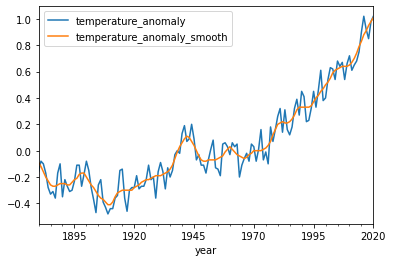

In [71]:
df.plot()

The simplest way to create a dfs0 file is to use the `to_dfs0` method on a Pandas dataframe.

In [72]:
df.to_dfs0("output/global_temperature.dfs0")

Let's read it back in again...

In [73]:
saved_dfs0 = Dfs0("output/global_temperature.dfs0")
saved_dfs0

<mikeio.Dfs0>
Timeaxis: TimeAxisType.CalendarNonEquidistant
Items:
  0:  temperature_anomaly <Undefined> (undefined)
  1:  temperature_anomaly_smooth <Undefined> (undefined)

By default, EUM types are undefined. But it can be specified.

In [74]:
from mikeio.eum import EUMType

df.to_dfs0("output/global_temperature_eum.dfs0", itemtype=EUMType.Temperature)

## EUM

In [75]:
from mikeio.eum import ItemInfo, EUMType, EUMUnit

EUMType.search("wind")


[Wind Velocity,
 Wind Direction,
 Wind friction factor,
 Wind speed,
 Depth of Wind,
 Wind friction speed]

In [76]:
EUMType.Wind_speed.units

[meter per sec, feet per sec, knot, km per hour, miles per hour]

## Precipitation data

In [77]:
df = pd.read_csv("data/precipitation.csv", parse_dates=True, index_col=0)
df.head()

,Precipitation station 1,Precipitation station 2,Precipitation station 3,Precipitation station 4,Precipitation station 5,Precipitation station 6,Precipitation station 7,Precipitation station 8,Precipitation station 9
date,,,,,,,,,
2001-01-01,0.0,0.000,0.021,0.071,0.000,0.000,0.025,0.025,0.000
2001-01-02,0.0,0.025,0.037,0.000,0.004,0.054,0.042,0.021,0.054
2001-01-03,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.042,0.000
2001-01-04,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2001-01-05,0.0,0.000,0.158,0.021,0.000,0.000,0.017,0.021,0.000


In [78]:
from mikecore.DfsFile import DataValueType

items = [ItemInfo(name, EUMType.Precipitation_Rate, EUMUnit.mm_per_hour, data_value_type=DataValueType.MeanStepBackward) for name in df.columns]

items

[Precipitation station 1 <Precipitation Rate> (mm per hour),
 Precipitation station 2 <Precipitation Rate> (mm per hour),
 Precipitation station 3 <Precipitation Rate> (mm per hour),
 Precipitation station 4 <Precipitation Rate> (mm per hour),
 Precipitation station 5 <Precipitation Rate> (mm per hour),
 Precipitation station 6 <Precipitation Rate> (mm per hour),
 Precipitation station 7 <Precipitation Rate> (mm per hour),
 Precipitation station 8 <Precipitation Rate> (mm per hour),
 Precipitation station 9 <Precipitation Rate> (mm per hour)]

In [79]:
items[0].data_value_type

<DataValueType.MeanStepBackward: 3>

In [80]:
df.to_dfs0("output/precipitation.dfs0",items=items)

## Selecting items

In [85]:
dfs = Dfs0("output/precipitation.dfs0")
ds = dfs.read(items=[1,4]) # select item by item number (starting from zero)
ds

<mikeio.DataSet>
Dimensions: (31,)
Time: 2001-01-01 00:00:00 - 2001-01-31 00:00:00
Items:
  0:  Precipitation station 2 <Precipitation Rate> (mm per hour)
  1:  Precipitation station 5 <Precipitation Rate> (mm per hour)

In [87]:
ds = dfs.read(items=["Precipitation station 6","Precipitation station 3"]) # or by name (in the order you like it)
ds

<mikeio.DataSet>
Dimensions: (31,)
Time: 2001-01-01 00:00:00 - 2001-01-31 00:00:00
Items:
  0:  Precipitation station 6 <Precipitation Rate> (mm per hour)
  1:  Precipitation station 3 <Precipitation Rate> (mm per hour)

In [100]:
items = list(reversed(range(1,8,2))) # not sure if this is useful, but it is possible ;-)
items

[7, 5, 3, 1]

In [102]:
ds = dfs.read(items=items)
ds

<mikeio.DataSet>
Dimensions: (31,)
Time: 2001-01-01 00:00:00 - 2001-01-31 00:00:00
Items:
  0:  Precipitation station 8 <Precipitation Rate> (mm per hour)
  1:  Precipitation station 6 <Precipitation Rate> (mm per hour)
  2:  Precipitation station 4 <Precipitation Rate> (mm per hour)
  3:  Precipitation station 2 <Precipitation Rate> (mm per hour)

Note that once you have read data into a Dataset, the item number no longer reflects the item number in the file!